# Literature Review of DP for machine learning

There's a lot some work already in the field. I've not looked at it much, having instead jumped straight into trying to apply DP to PPCA. 

Most relevant is Berlioz (2015) paper, in which they have applied DP to matrix factorisation.

Reading the lit section of Berlioz, in the area of distributed recommender systems:

  - Canny (2002) - distributed SVM.
  - Vallet (20??) - 

"Canny proposed a decentralized storage of user profiles, which requires the adversary to compromise multiple systems when attacking a distributed recommender [3]. Vallet et al. [17] have shown how MF techniques can be leveraged to allow a central server to provide accurate recommendations without retention of user data, storing it on the client side instead."

Berlioz, A., Friedman, A., Kaafar, M.A., Boreli, R. and Berkovsky, S., 2015, September. Applying differential privacy to matrix factorization. In Proceedings of the 9th ACM Conference on Recommender Systems (pp. 107-114). ACM.

## Expectation Maximisation for PCA

We have a prior over the latent variables $p(z) = N(z|0,I)$

We have a conditional distribution over the outputs $p(x|z) = N(x|Wz + \mu, \sigma^2 I)$

For the Expectation step...

1. We write $p(x,z) = p(x|z) p(z)$
2. $ln\;p(X,Z|\mu, W, \sigma^2) = \sum_n \left( ln\; p(x_n | z_n) p(z_n) \right)$ (we can do this summation because we assume each point is IID).
3. We want to know $E[ln\;p(X,Z | \mu, W, \sigma^2)] = E\Big[\sum_n \left[ ln\;p(x|z) + ln\;p(z) \right]\Big]$
4. We expand out these distributions and apply the log to them, to get a long expression, importantly the values that are missing that we need are $E[z_n]$ and $E[z_n z_n^\top]$. We can find these from earlier work on PCA.

using $M = W^\top W + \sigma I$

we have this expression for $p(z|x)$:

$p(z|x) = N(z|M^{-1} W^\top (x-\mu), \sigma^2 M^{-1})$

This allows us to find the values for $E[z_n]$ and $E[z_n z_n^\top]$:

$E[z_n] = M^{-1} W^\top (x-\mu)$

$E[z_n z_n^\top] = \sigma^2 M^{-1} + E[z_n]E[z_n]^\top$ (see identity proof at bottom of document)

For the Maximisation step...

We differentiated the expression for $E[ln\;p(X,Z|\mu, W, \sigma^2)]$ wrt $W$ and $\sigma^2$:

$W_{new} = \Big[\sum_n (x_n - \bar{x}) E[z_n]^\top\Big] \Big[\sum_n E[z_n z_n^\top] \Big]^{-1}$

$\sigma^2_{new} = ...$

In [1]:
#First set up our dataset, etc: A 3d dataset
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)

Dn = 3 #number of dimensions in the observed variables.
Mn = 2 #number of dimensions the latent variables will have (principal components)
N = 200 #number of data points

#initial values of parameters sigma^2 and the transform W (between the observed space and the latent space)
sigsqr = 1.0 #starting value of the noise variance sigma^2
W = np.random.randn(Dn,Mn) * .01 #starting value of the transform W

#data generation
x = np.random.randn(Dn,N)
x[1,:] += x[0,:]*1.5 #some covariance
x[0,:] = x[0,:] * 5.0
x[1,:] = x[1,:] * 2.0
x[2,:] -= x[1,:] * 4
x = x + np.random.randn(Dn,N) * .0

x = x * 1.0
#used later for efficiency.
zeromean_x = (x.T - np.mean(x,1)).T

Plot of the data (showing each pair of dimensions)

In [2]:
for d1 in range(Dn):
    for d2 in range(d1):
        plt.figure()
        plt.plot(x[d1,:],x[d2,:],'x')
        #plt.xlim([-15,15])
        #plt.ylim([-15,15])
        plt.title('%d vs %d' % (d1+1,d2+1))

The expectation maximisation

In [3]:
Ezz = []
Ez = []
for n in range(N):
    Ezz.append(np.zeros([Mn,Mn]))
    Ez.append(np.zeros(Mn)[:,None])

sig_store = []
for it in range(100):
    #Expectation, find values of components...
    M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
    invM = np.linalg.inv(M) #TODO Solve using linalg.solve (MORE STABLE)
    old_Ez = Ez[:] #Use Cholesky decomp to do this inversion in a more stable way.

    for n in range(N): #TODO: Vectorise
        Ez[n] = np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None] #MxD . Dx1 = Mx1
        Ezz[n] = sigsqr * invM + np.dot(Ez[n],Ez[n].T)
    #Maximisation 
    #Next We've differentiated E[ln p(X,Z|parameters)] and,
    #setting equal to zero, we can find what the parameters equal to maximise this    
    
    partA = np.zeros([Dn,Mn])
    for n in range(N):
        partA += np.dot(zeromean_x[:,n][:,None],Ez[n].T)
        #if n==5:
        #    print np.dot(zeromean_x[:,n][:,None],Ez[n].T)
        #    print np.dot(zeromean_x[:,n][:,None],np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None].T)
        #    print np.dot(np.dot(zeromean_x[:,n][:,None],zeromean_x[:,n][:,None].T),np.dot(W,invM.T))
        #    print "----"

        
    partB = np.zeros([Mn,Mn])
    for n in range(N):
        partB += Ezz[n]
    new_W = np.dot(partA, np.linalg.inv(partB)) #TODO Replace inverse
    temp = 0
    for n in range(N):
        #np.linalg.norm() replace below
        temp += np.dot(zeromean_x[:,n],zeromean_x[:,n]) - 2.0*np.dot(np.dot(Ez[n].T, new_W.T),zeromean_x[:,n])
        temp += np.trace(np.dot(Ezz[n],np.dot(new_W.T,new_W)))
    new_sigsqr = (1.0/(N*Dn)) * temp #changed brackets

    sig_store.append(new_sigsqr)
   
    W = new_W.copy()
    sigsqr = new_sigsqr

print W
import matplotlib.pyplot as plt
%matplotlib inline

[[-0.590576  4.297617]
 [-2.147801  2.216289]
 [ 8.693151 -8.818607]]


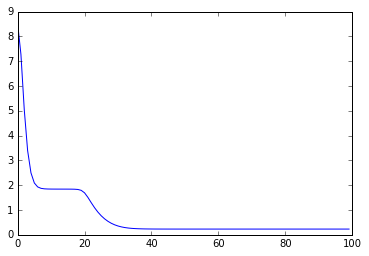

In [4]:
plt.plot(np.sqrt(sig_store))

In this plot, our predicted values (in blue x) overestimate the noise, this is because the $\sigma^2$ is large, to help explain the variance in the other dimensions that we can't explain using our model with only one dimension in the latent variable.

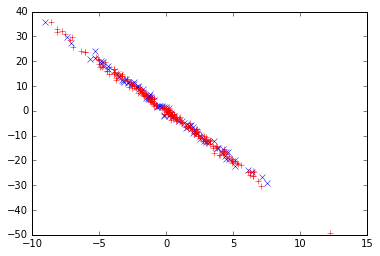

In [5]:
zs = np.random.multivariate_normal(np.zeros(Mn),np.eye(Mn),100).T
#xpred = np.dot(W,zs.T) + np.random.multivariate_normal(np.zeros(Dn),np.eye(Dn)*sigsqr,100).T
xpred = np.dot(W,zs) + np.random.multivariate_normal(np.zeros(Dn),np.eye(Dn)*sigsqr,100).T


plt.plot(xpred[1,:],xpred[2,:],'x')
#plt.xlim([-10,10])
#plt.ylim([-10,10])
plt.plot(x[1,:],x[2,:],'+r')

In [6]:
cov = np.dot(zeromean_x,zeromean_x.T)
#cov = np.array([[2,1],[1,2]])
u,v,w = np.linalg.svd(cov)
print w
print W
normed_W = W / np.sqrt(np.sum(W**2,0))
print normed_W.T

[[-0.272558 -0.232772  0.933557]
 [ 0.962089 -0.056012  0.266922]
 [-0.009842  0.970917  0.239214]]
[[-0.590576  4.297617]
 [-2.147801  2.216289]
 [ 8.693151 -8.818607]]
[[-0.06581  -0.239336  0.968704]
 [ 0.427313  0.220366 -0.876836]]


In [7]:
#print M
#print np.linalg.inv(M)
#print W
#print zeromean_x[:,0]
print sigsqr
print np.dot(W.T,W)
M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
invM = np.linalg.inv(M)

print np.dot(np.dot(np.linalg.inv(M),W.T),zeromean_x[:,0])
print old_Ez[0]
print Ez[0]
print np.dot(np.dot(invM,W.T),zeromean_x[:,0])

[ 0.053269]
[[  80.532708  -83.959703]
 [ -83.959703  101.149285]]
[-1.9466    0.041428]
[[-1.94783 ]
 [ 0.040582]]
[[-1.94721 ]
 [ 0.041009]]
[-1.9466    0.041428]


In [8]:
def sqrtm(m):
    u,l,v = np.linalg.svd(m)
    for x in range(m.shape[0]):
        for y in range(m.shape[1]):
            if np.abs(m[x,y]-m[y,x])>0.001:
                print m
                raise Exception("Not diagonal")
    return np.dot(u,np.diag(np.sqrt(l)))
    #return np.dot(np.dot(u,np.diag(np.sqrt(l))),np.linalg.inv(v))
    
a = np.array([[4,2,3],[2,8,1],[3,1,5]])
b = sqrtm(a)
print b
print np.dot(b,b.T)

[[-1.522377  0.928943 -0.905226]
 [-2.359487 -1.550749  0.16733 ]
 [-1.416288  1.584967  0.694267]]
[[ 4.  2.  3.]
 [ 2.  8.  1.]
 [ 3.  1.  5.]]


In [10]:
print np.linalg.det(cov)
U,l,w = np.linalg.svd(cov)
L = np.diag(l)
#print np.dot(U,sqrtm(L-sigsqr*np.eye(Mn)))
print normed_W

648271715.641
[[-0.06581   0.427313]
 [-0.239336  0.220366]
 [ 0.968704 -0.876836]]


Each iteration
..
We have a prior over the latent variables $p(z) = N(z|0,I)$

We have a conditional distribution over the outputs $p(x|z) = N(x|Wz + \mu, \sigma^2 I)$

For the Expectation step...

1. We write $p(x,z) = p(x|z) p(z)$
2. $ln\;p(X,Z|\mu, W, \sigma^2) = \sum_n \left( ln\; p(x_n | z_n) p(z_n) \right)$ (we can do this summation because we assume each point is IID).
3. We want to know $E[ln\;p(X,Z | \mu, W, \sigma^2)] = E\Big[\sum_n \left[ ln\;p(x|z) + ln\;p(z) \right]\Big]$
4. We expand out these distributions and apply the log to them, to get a long expression, importantly the values that are missing that we need are $E[z_n]$ and $E[z_n z_n^\top]$. We can find these from earlier work on PCA.

using $M = W^\top W + \sigma I$

we have this expression for $p(z|x)$:

$p(z|x) = N(z|M^{-1} W^\top (x-\mu), \sigma^2 M^{-1})$

This allows us to find the values for $E[z_n]$ and $E[z_n z_n^\top]$:

$E[z_n] = M^{-1} W^\top (x-\mu)$

$E[z_n z_n^\top] = \sigma^2 M^{-1} + E[z_n]E[z_n]^\top$ (see identity proof at bottom of document)

For the Maximisation step...

We differentiated the expression for $E[ln\;p(X,Z|\mu, W, \sigma^2)]$ wrt $W$ and $\sigma^2$:

$W_{new} = \Big[\sum_n (x_n - \bar{x}) E[z_n]^\top\Big] \Big[\sum_n E[z_n z_n^\top] \Big]^{-1}$

$\sigma^2_{new} = ...$

In [11]:
Ez[0]

array([[-1.94721 ],
       [ 0.041009]])

In [12]:
Ezz[0]

array([[ 3.796505, -0.075806],
       [-0.075806,  0.005566]])

### Identity $E[(a+\mu)(a+\mu)^\top] = cov(a) + \mu \mu^\top$

The final term above comes from this identity:

$E[(a+\mu)(a+\mu)^\top] = E[a a^\top] + E[a \mu^\top] + E[\mu a^\top] + E[\mu \mu^\top]$ 

We note that $E[\mu \mu^\top]=\mu \mu^\top$
and
$E[a \mu^\top]= E[a] \mu ^\top = 0$. 

Leaving just: $E[(a+\mu)(a+\mu)^\top] = E[a a^\top] + \mu \mu^\top = cov(a) + \mu \mu^\top$



In [13]:
(W/np.sqrt(np.sum(W**2,1))).T

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

In [14]:
W

array([[-0.590576,  4.297617],
       [-2.147801,  2.216289],
       [ 8.693151, -8.818607]])

In [15]:
np.rank(W)

/home/lionfish/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


2

In [16]:
#Ez

## Online Expectation Maximisation and Differential Privacy

To summarise the aims:

 - We want users to be able to update the estimates of $W$ and $\sigma^2$. I'm currently using the EM algorithm, but this completely replaces the original values each 'iteration'. I'm trying to make each person a single iteration of the EM algorithm, but one could also sum over the people to find the two terms of $W$. The problem is that, to sum over people we have to apply a lot of noise (as they will be releasing their individual values during the summation).
 
 - We alternatively could use ML, and solve using gradients, rather than set the deriviative to zero.

### EM and people

Can I iterate through the people one at a time?

Below I try to do this, but as the number of people in the sample approach one, the algorithm fails to converge. This isn't particularly surprising.. Maybe it's the $\Big[\sum^N_{n=1} E[z_n z_n^\top] \Big]^{-1}$ inverse that gets too large?

I've dealt with it below by smoothing the change each iteration (2nd order kalman filter). It's a bit flakey and very slow but it does converge.

This doesn't seem a good solution... 

In [17]:
Ezz = []
Ez = []


N = 100 # zeromean_x.shape[1] #number of people in each group.
print N
for n in range(N):
    Ezz.append(np.zeros([Mn,Mn]))
    Ez.append(np.zeros(Mn)[:,None])

sig_store = []
indx = 0
for it in range(1000): #range(200000/N):
    x = zeromean_x[:,indx:(indx+N)]
    indx += N
    if (indx+N >= zeromean_x.shape[1]):
        indx = 0
    #x = (x.T - np.mean(x,1)).T
    
    M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
    invM = np.linalg.inv(M) #TODO Solve using linalg.solve (MORE STABLE)
    old_Ez = Ez[:] #Use Cholesky decomp to do this inversion in a more stable way.

    for n in range(N): #TODO: Vectorise
        Ez[n] = np.dot(np.dot(invM,W.T),x[:,n])[:,None] #MxD . Dx1 = Mx1
        Ezz[n] = sigsqr * invM + np.dot(Ez[n],Ez[n].T)
    #Maximisation 
    #Next We've differentiated E[ln p(X,Z|parameters)] and,
    #setting equal to zero, we can find what the parameters equal to maximise this    

    partA = np.zeros([Dn,Mn])
    for n in range(N):
        partA += np.dot(x[:,n][:,None],Ez[n].T)
       
    partB = np.zeros([Mn,Mn])
    for n in range(N):
        partB += Ezz[n]
    #print partB
    new_W = np.dot(partA, np.linalg.inv(partB)) #TODO Replace inverse
    temp = 0
    for n in range(N):
        #np.linalg.norm() replace below
        temp += np.dot(x[:,n],x[:,n]) - 2.0*np.dot(np.dot(Ez[n].T, new_W.T),x[:,n])
        temp += np.trace(np.dot(Ezz[n],np.dot(new_W.T,new_W)))
    new_sigsqr = (1.0/(N*Dn)) * temp #changed brackets

    sig_store.append(new_sigsqr)
   
    W = W*0.999 + new_W.copy() * 0.001
    sigsqr = sigsqr*0.999 + new_sigsqr * 0.001

print "---"
print W
import matplotlib.pyplot as plt
%matplotlib inline

100
---
[[-0.592776  4.296817]
 [-2.140661  2.195482]
 [ 8.694882 -8.824825]]


### Secure Multiparty Computation

We need to be able to keep the output private, but combine the responses from several people in each batch (one person doesn't seem to work well). To solve this issue, but still use batch processing:

 - Note first that $E[z_n]$ and $E[z_n z_n]$ can be calculated locally (once the mean and current estimates of $W$, $\sigma^2$ are provided).
 
We can use the locally calculated values, and add up these...
 
Steps:

 1. Find the sum of everyone's $\mathbf{x}$s. Could use Fast Mean Finder (see below)
 2. Find the mean (divide by N), $\bar{x}$
 3. Pass this and estimates of W and $\sigma^2$ to all users.
 4. Let them calculate $E[z_n]$ and $E[z_n z_n^\top]$ locally. (we could pass $M$ to save everyone needing to do computation locally).
 5. Locally find $p_1 = (x_n - \bar{x}) E[z_n]^{\top}$.
 6. Locally find $p_2 = |x_n - x|^2 - 2E[z_n]^\top W^\top_{new} (x_n - \bar{x}) + Tr(E[z_n z_n^\top] W^\top_{new} W_{new})$
 7. For $E[z_n]$, $E[z_n z_n^\top]$, $p_1$ and $p_2$ add sufficient noise to hide $x$ when added, maybe using the Fast Mean Finder (below).
 8. We now need to add up all the $p_1$s, $p_2$s and all the $E[z_n z_n^\top]$.
 9. We can now find $W_{new}$ and $\sigma^2_{new}$.
 
The summations take the time, and we can choose to balance noise and accuracy using the 'fast mean finder' below.

We can also batch the users together and run the EM algorithm on a smaller number of people each time. I'm not sure if there's any advantage in this.

We also need to know the sensitivity of the output of, $\sum{x_n E[z_n]^\top} \Big(E[z_n z_n^\top]\Big)^{-1}$

We have to put bounds on $x$ and $z$. For now these will be arbitrary $x_{max}$ and $z_{max}$.

The best way I can see to add DP noise to the above is to treat the two summations seperately, with the first, we can add $x_{max} . z_{max}$ proportional noise to the sum. 



[[  4.164204]
 [  3.201385]
 [-12.8166  ]]


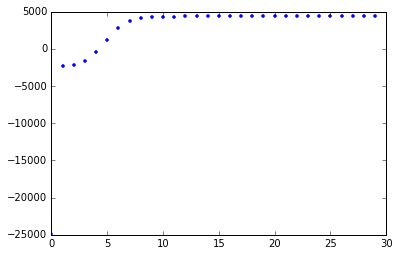

In [19]:
#copied from above...
import numpy as np
import matplotlib.pyplot as plt

Dn = 3 #number of dimensions in the observed variables.
Mn = 1 #number of dimensions the latent variables will have (principal components)
N = 200 #number of data points


def generate_data(Dn,N):
    x = np.random.randn(Dn,N)
    x[1,:] += x[0,:]*1.5 #some covariance
    x[0,:] = x[0,:] * 5.0
    x[1,:] = x[1,:] * 2.0
    x[2,:] -= x[1,:] * 4
    return x + np.random.randn(Dn,N) * .0

x = generate_data(Dn,N)
zeromean_x = (x.T - np.mean(x,1)).T

def run_normal_EM(x):
    #initial values of parameters sigma^2 and the transform W (between the observed space and the latent space)
    sigsqr = 1.0 #starting value of the noise variance sigma^2
    W = np.random.randn(Dn,Mn) * .01 #starting value of the transform W

    Ezz = []
    Ez = []
    for n in range(N):
        Ezz.append(np.zeros([Mn,Mn]))
        Ez.append(np.zeros(Mn)[:,None])

    expect_list = []
    for it in range(30):
        negloglike = 0
        for n in range(N):
            #obviously can be more efficient (i.e. moving terms that don't depend on n out, but this is copied verbatim from the book)
            negloglike += (Dn/2.0) * np.log(2*np.pi*sigsqr)
            negloglike += .5 * np.trace(Ezz[n])
            negloglike += (1.0/(2.0*sigsqr))*np.dot(zeromean_x[:,n],zeromean_x[:,n])
            negloglike -= (1.0/sigsqr) * np.dot(np.dot(Ez[n], W.T),zeromean_x[:,n])
            negloglike += (1.0/(2.0*sigsqr)) * np.trace(Ezz[n],np.dot(W.T,W)) 
        expect_list.append(-negloglike)

        #Expectation, find values of components...
        M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
        invM = np.linalg.inv(M) #TODO Solve using linalg.solve (MORE STABLE)
        old_Ez = Ez[:] #Use Cholesky decomp to do this inversion in a more stable way.

        for n in range(N): #TODO: Vectorise
            Ez[n] = np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None] #MxD . Dx1 = Mx1
            Ezz[n] = sigsqr * invM + np.dot(Ez[n],Ez[n].T)
        #Maximisation 
        #Next We've differentiated E[ln p(X,Z|parameters)] and,
        #setting equal to zero, we can find what the parameters equal to maximise this    

        partA = np.zeros([Dn,Mn])
        for n in range(N):
            partA += np.dot(zeromean_x[:,n][:,None],Ez[n].T)
            #if n==5:
            #    print np.dot(zeromean_x[:,n][:,None],Ez[n].T)
            #    print np.dot(zeromean_x[:,n][:,None],np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None].T)
            #    print np.dot(np.dot(zeromean_x[:,n][:,None],zeromean_x[:,n][:,None].T),np.dot(W,invM.T))
            #    print "----"


        partB = np.zeros([Mn,Mn])
        for n in range(N):
            partB += Ezz[n]
        new_W = np.dot(partA, np.linalg.inv(partB)) #TODO Replace inverse
        temp = 0
        for n in range(N):
            #np.linalg.norm() replace below
            temp += np.dot(zeromean_x[:,n],zeromean_x[:,n]) - 2.0*np.dot(np.dot(Ez[n].T, new_W.T),zeromean_x[:,n])
            temp += np.trace(np.dot(Ezz[n],np.dot(new_W.T,new_W)))
        new_sigsqr = (1.0/(N*Dn)) * temp #changed brackets

        W = new_W.copy()
        sigsqr = new_sigsqr

    return expect_list, W, sigsqr

def run_DP_EM(x):
    #initial values of parameters sigma^2 and the transform W (between the observed space and the latent space)
    sigsqr = 1.0 #starting value of the noise variance sigma^2
    W = np.random.randn(Dn,Mn) * .01 #starting value of the transform W

    Ezz = []
    Ez = []
    for n in range(N):
        Ezz.append(np.zeros([Mn,Mn]))
        Ez.append(np.zeros(Mn)[:,None])

    expect_list = []
    for it in range(30):
        negloglike = 0
        for n in range(N):
            #obviously can be more efficient (i.e. moving terms that don't depend on n out, but this is copied verbatim from the book)
            negloglike += (Dn/2.0) * np.log(2*np.pi*sigsqr)
            negloglike += .5 * np.trace(Ezz[n])
            negloglike += (1.0/(2.0*sigsqr))*np.dot(zeromean_x[:,n],zeromean_x[:,n])
            negloglike -= (1.0/sigsqr) * np.dot(np.dot(Ez[n], W.T),zeromean_x[:,n])
            negloglike += (1.0/(2.0*sigsqr)) * np.trace(Ezz[n],np.dot(W.T,W)) 
        expect_list.append(-negloglike)

        #Expectation, find values of components...
        M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
        invM = np.linalg.inv(M) #TODO Solve using linalg.solve (MORE STABLE)
        old_Ez = Ez[:] #Use Cholesky decomp to do this inversion in a more stable way.

        for n in range(N): #TODO: Vectorise
            Ez[n] = np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None] #MxD . Dx1 = Mx1
            Ezz[n] = sigsqr * invM + np.dot(Ez[n],Ez[n].T)
        #Maximisation 
        #Next We've differentiated E[ln p(X,Z|parameters)] and,
        #setting equal to zero, we can find what the parameters equal to maximise this    

        partA = np.zeros([Dn,Mn])
        for n in range(N):
            partA += np.dot(zeromean_x[:,n][:,None],Ez[n].T)
            #if n==5:
            #    print np.dot(zeromean_x[:,n][:,None],Ez[n].T)
            #    print np.dot(zeromean_x[:,n][:,None],np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None].T)
            #    print np.dot(np.dot(zeromean_x[:,n][:,None],zeromean_x[:,n][:,None].T),np.dot(W,invM.T))
            #    print "----"


        partB = np.zeros([Mn,Mn])
        for n in range(N):
            partB += Ezz[n]
        new_W = np.dot(partA, np.linalg.inv(partB)) #TODO Replace inverse
        temp = 0
        for n in range(N):
            #np.linalg.norm() replace below
            temp += np.dot(zeromean_x[:,n],zeromean_x[:,n]) - 2.0*np.dot(np.dot(Ez[n].T, new_W.T),zeromean_x[:,n])
            temp += np.trace(np.dot(Ezz[n],np.dot(new_W.T,new_W)))
        new_sigsqr = (1.0/(N*Dn)) * temp #changed brackets

        W = new_W.copy()
        sigsqr = new_sigsqr

    return expect_list, W, sigsqr

expect_list_normal, W, sigsqr=run_normal_EM(x)
expect_list_dp, W, sigsqr=run_DP_EM(x)

print W
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(expect_list_normal,'.')

## Fast Mean Finder

Thinking about how Secure Multiparty computation (https://en.wikipedia.org/wiki/Secure_multi-party_computation) does adding up, it takes O(N) time and is done by person 0 adding their value to a random value r, passing this sum $s_1$ to person 1, who adds their value to this and passing $s_2$, etc. To also make this differentially private, people need to add noise proportional to the domain of their data, divided by N: $S/N$. At the end of the loop the noise will be of scale $S$

I worry how long all this takes, including finding the mean: It takes O(N) time to make it work for N people...

Instead we could have $\sqrt{N}$ loops, each with $\sqrt{N}$ people in each. We add up the output of all the loops.

So in each loop, each person adds $S/\sqrt{N}$, so the amount of noise at the end of each loop is $S\sqrt{N}$. So we've got $\sqrt{N}$ more noise than before, but the time to complete the algorithm takes only $O(\sqrt{N})$ time.

Other choices of how the loops and noise are weighted can be chosen, depending on if time or accuracy is most important.

## Things to find

 - Emperically how long does it take to converge with the addition of DP?
 - What constraints or bounds can we put on this convegence?
 - Could we combine the numbers from multiple runs of the EM algorithm...?
 
To deal with:

 - The outputs aren't both scalar; $W$ is a matrix... I've not seen how to deal with matrix outputs.
 
I have seen how to handle vector valued outputs:

http://ergodicity.net/2013/03/21/generating-vector-valued-noise-for-differential-privacy/

 - I'm not clear why this uses the L2 norm? In http://www.stat.cmu.edu/~arinaldo/papers/hall13a.pdf the author states: "In the case of vector valued output the sensitivity is typically measured in the Euclidean norm or the l1-norm". Which?!
 
### So can we apply this to matrix valued outputs?

I assume we can, if we assume that all the columns can just be stacked, for the purposes of privacy : Wrong.

Use a matrix norm (e.g. spectral norm)?

Our problem now is knowing what the sensitivity of the $E[z_n]$ vector elements is.

Just comparing to its prior:

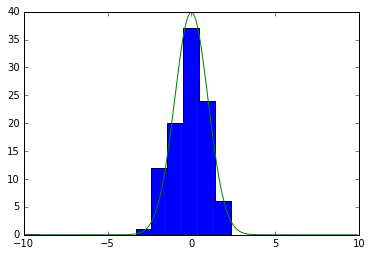

In [20]:
# getting the values of E[z] from the earlier calculation

zs = [v[0][0] for v in Ez]
#zs = np.random.randn(1000)
plt.hist(zs,bins=21,range=[-10,10]);

#compare to its prior
import scipy.stats as stats
z = np.arange(-10,10,0.1)
plt.plot(z,stats.norm.pdf(z,0,1)*len(zs))

The distribution is more spread than its prior. WRONG: This just indicates insufficient convergence.

1.02384348337


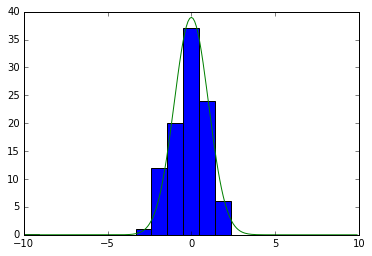

In [21]:
# getting the values of E[z] from the earlier calculation

zs = [v[0][0] for v in Ez]
#zs = np.random.randn(1000)
plt.hist(zs,bins=21,range=[-10,10]);

#compare to its prior
import scipy.stats as stats
z = np.arange(-10,10,0.1)
std = np.sqrt(np.var(zs))
plt.plot(z,stats.norm.pdf(z,0,std)*len(zs))
print std

Why is it still about the same variance as its prior? See "Convergence of p(z|x)".

We can use this result (but need to prove it). We can say that $E[z_n]$ has a sensitivity of 10, and a probability of exceeding this of...


In [22]:
2*stats.norm.cdf(-5,0,1)

5.7330314375838655e-07

Using the above constraints we can say that the sensitivity of any element of $\mathbf{x} E[z_n]^\top$, is the sensitivity of $x_{ni}$ (which we'll say is from -1 to 1, so therefore 2) times the sensitivity of $E[z_{n}]_i$ which we've stated above is 10. So the sensitivity is 20. We'll call this $\Delta$ for now. Or $\Delta_{Ez}$ times $\Delta_x$.

# What matrix norm should I use for differential privacy?

If we assume we provide all the elements in $W$, what norm should we use to calculate the sensitivity? 

- **The spectral norm?** we should find the spectral-norm: The largest singular value of A. I.e. the square root of the largest eigenvalue of $W^\top W$:

$||W||_2 = \sqrt{\lambda_{max}(W^\top W)}$

- Or as we're releasing the whole of $W$, I feel that maybe we should use the **l1-norm**? Biggest column sum.

- There's the $\infty$-norm. Biggest row-sum.

- Quite common is the l2,1-(entrywise)-norm: $\sqrt{\sum_{all}{a_{ij}^2}}$

Although the l2 (spectal) norm is quite difficult to estimate given the arbitrary values the vectors $\mathbf{x}$ and $E[z_n]$ might hold. There is an upper bound on them of: $||M||_2 \leq \sqrt{\sum^D_i \sum^M_j |m_{ij}|^2}$

### Applying to $\sum{x_n E[z_n]^\top}$

First we note that the summation we want is over $(\mathbf{x} E[z_n]^\top)$, each element of this matrix is of the form $x_i E[z_n]_j$. 

Given the 'absolute' operator, the sensitivity of each element $|m_ij|$ is bound between zero, and the product of the maximum of $x$ and $E[z]$, ($x_{max}=1$ and $z_{max}$ respectively) the product of which I'll call $\Delta$.

So the upper bound on $||M||_2$ is:

$$||M||_2 \leq \sqrt{DM\Delta^2}

For 10 input dimensions (D) and 5 latent dimensions (M) with $z_{max}$ set to 5 (as mentioned above) we have an L2 sensitivity on the product of $x$ and $E[z]$ of: $\sqrt{10 \times 5 \times 5^2} \approx 35.4$.

If there are 100 samples, each one will need Laplae(0.354) noise added to each ???

***It might be better to apply DP to each of the vectors before doing the computation***
http://ergodicity.net/2013/03/21/generating-vector-valued-noise-for-differential-privacy/

###

# Overview of new plan

Ideas:

 - Apply DP to the inputs of PPCA and **introduce new noise term to PPCA**
     - Question: Isn't the current noise term sufficient? (i.e. can we really describe more by adding a new term?)
         - What about 